<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/Datenanalyse/EDA_ChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## import modules

import io, os, sys, setuptools, tokenize
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime
from datetime import timedelta
from math import sqrt

In [3]:
# Größe der Plots festlegen
matplotlib.rcParams['figure.figsize'] = (16, 9)

In [4]:
# Allgemeine Angaben
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

# tz, altitude, name = 'Europe/Berlin', 70, 'SanktAugustin'
# tus = pvlib.location.Location(latitude, longitude, tz, altitude, name)

In [5]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'Messdaten_CAMS_GHI.csv'
name_Vorhersage = 'Vorhersagedaten_CAMS_VarIdx.csv'

folder_import = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
folder_export = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

In [6]:
df_Vorhersage = pd.read_csv(folder_import + name_Vorhersage)
df_Vorhersage['Datetime'] = pd.to_datetime(df_Vorhersage['Datetime'])

# df_Vorhersage.set_index('Datetime', inplace=True)
# df_Vorhersage.index = pd.to_datetime(df_Vorhersage.index)

In [7]:
df_Messwerte = pd.read_csv(folder_import + name_Messwerte)
df_Messwerte['Datetime'] = pd.to_datetime(df_Messwerte['Datetime'])

# df_Messwerte.set_index('Datetime', inplace=True)
# df_Messwerte.index = pd.to_datetime(df_Messwerte.index)

## Tägliche Durchschnittswerte der gemessenen UV und Glo-Strahlung

In [8]:
# Display basic information about the datasets
info_Vorhersage = df_Vorhersage.info()
info_Messwerte = df_Messwerte.info()

print(info_Messwerte)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10224 entries, 0 to 10223
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Datetime       10224 non-null  datetime64[ns]
 1   aod469         10224 non-null  float64       
 2   aod550         10224 non-null  float64       
 3   gtco3          10224 non-null  float64       
 4   uvbed          10224 non-null  float64       
 5   uvbedcs        10224 non-null  float64       
 6   hcc            10224 non-null  float64       
 7   lcc            10224 non-null  float64       
 8   tcc            10224 non-null  float64       
 9   index_sigma    1496 non-null   float64       
 10  index_coimbra  1496 non-null   float64       
 11  index_stein    1496 non-null   float64       
 12  kc             1496 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96732 entries, 0

In [9]:
# Vorhersage und Messung zusammenfügen:

df_merged = pd.merge(df_Messwerte, df_Vorhersage, on = 'Datetime', how = 'inner')

In [21]:
df_merged['Residuals_UV'] = df_merged['UVI'] - df_merged['uvbed']

## Tägliche/Stündliche Durchschnittswerte der gemessenen UV und Glo-Strahlung

In [10]:
# Calculating MAE and RMSE for uvbed predictions vs. UVI measurements
mae_uv = np.mean(np.abs(df_merged['UVI'] - df_merged['uvbed']))
rmse_uv = np.sqrt(np.mean((df_merged['UVI'] - df_merged['uvbed']) ** 2))

# Calculating MAE and RMSE for uvbed predictions vs. UVI measurements
mae_uvcs = np.mean(np.abs(df_merged['UVI'] - df_merged['uvbedcs']))
rmse_uvcs = np.sqrt(np.mean((df_merged['UVI'] - df_merged['uvbedcs']) ** 2))

In [11]:
  print(mae_uv, rmse_uv, mae_uvcs, rmse_uvcs)

0.33581164373521055 0.6515087270321994 0.5182937385309853 0.9886291986080578


In [12]:
# Bestimme des Tages und der Stunde für jede Zeile
df_merged['Date'] = df_merged['Datetime'].dt.date
df_merged['Hour'] = df_merged['Datetime'].dt.hour

# Bestimmen der Täglichen und stündlichen Mittelwerte
daily_aggregates = df_merged.groupby('Date')[['GHI', 'UVI', 'uvbed', 'uvbedcs']].mean()
hourly_aggregates = df_merged.groupby('Hour')[['GHI', 'UVI', 'uvbed', 'uvbedcs']].mean()

daily_aggregates.index = pd.to_datetime(daily_aggregates.index)
weekly_aggregates = daily_aggregates.resample('W').mean()

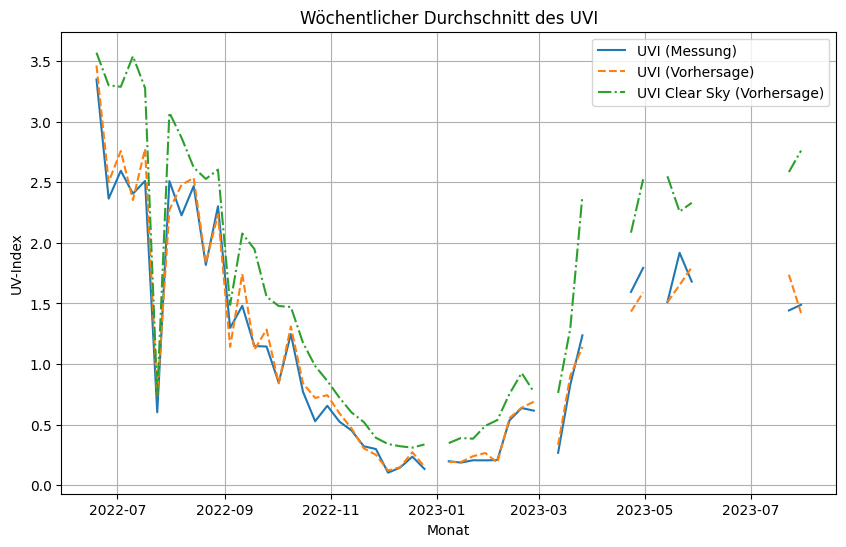

In [13]:
# 1. Wöchentlicher Durchschnitt
plt.figure(figsize=(10, 6))
plt.plot(weekly_aggregates.index, weekly_aggregates['UVI'], label='UVI (Messung)')
plt.plot(weekly_aggregates.index, weekly_aggregates['uvbed'], label='UVI (Vorhersage)', linestyle='--')
plt.plot(weekly_aggregates.index, weekly_aggregates['uvbedcs'], label='UVI Clear Sky (Vorhersage)', linestyle='-.')
plt.title('Wöchentlicher Durchschnitt des UVI')
plt.xlabel('Monat')
plt.ylabel('UV-Index')
plt.legend()
plt.grid()
plt.show()

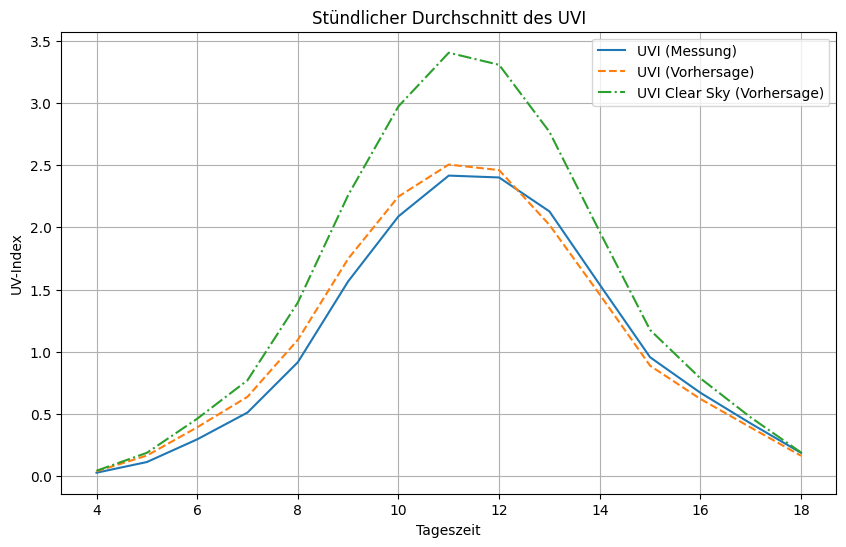

In [14]:
# 2. Stündlicher Durchschnitt
plt.figure(figsize=(10, 6))
plt.plot(hourly_aggregates.index, hourly_aggregates['UVI'], label='UVI (Messung)')
plt.plot(hourly_aggregates.index, hourly_aggregates['uvbed'], label='UVI (Vorhersage)', linestyle='--')
plt.plot(hourly_aggregates.index, hourly_aggregates['uvbedcs'], label='UVI Clear Sky (Vorhersage)', linestyle='-.')
plt.title('Stündlicher Durchschnitt des UVI')
plt.xlabel('Tageszeit')
plt.ylabel('UV-Index')
plt.legend()
plt.grid()
plt.show()

## Anomaly Detektion:

In [15]:
# Berechnen der residuen
df_merged['Residuals_UV'] = df_merged['UVI'] - df_merged['uvbed']
df_merged['Residuals_UVcs'] = df_merged['UVI'] - df_merged['uvbedcs']

# Identifizieren von Residuuen größer 2 Standardabweichungen
residual_threshold = 2 * df_merged['Residuals_UV'].std()
anomalies = df_merged[np.abs(df_merged['Residuals_UV']) > residual_threshold]

# Ebenfalls für UVBEDCS
residual_threshold_cs = 2 * df_merged['Residuals_UVcs'].std()
anomalies = df_merged[np.abs(df_merged['Residuals_UVcs']) > residual_threshold_cs]

In [16]:
# Add month information to the dataset
df_merged['Month'] = df_merged['Datetime'].dt.month
monthly_aggregates = df_merged.groupby('Month')[['UVI', 'uvbed', 'uvbedcs']].mean()

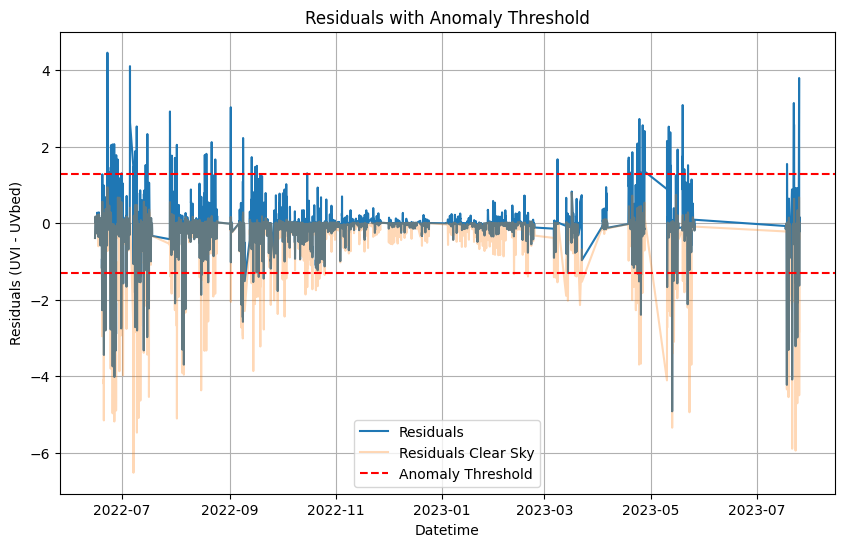

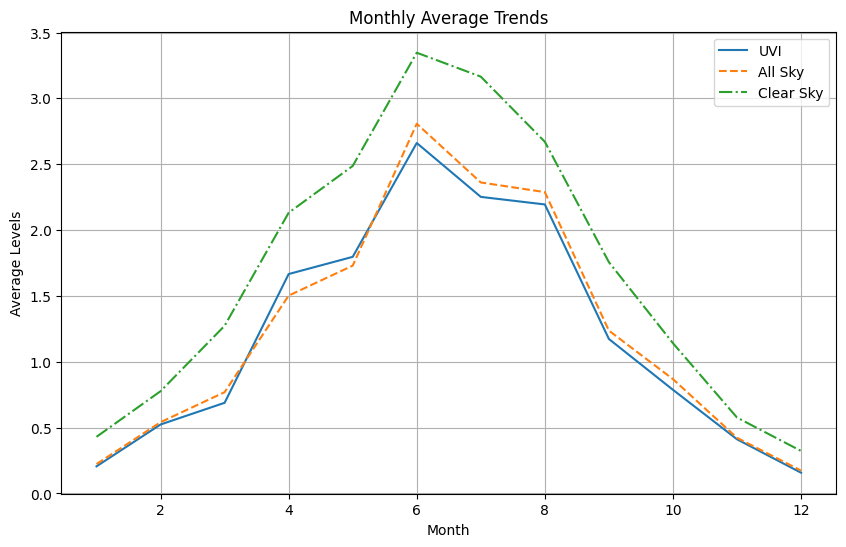

In [17]:
# Visualizations and summaries
# 1. Residuals and Anomalies
plt.figure(figsize=(10, 6))
plt.plot(df_merged['Datetime'], df_merged['Residuals_UV'], label='Residuals')
plt.plot(df_merged['Datetime'], df_merged['Residuals_UVcs'], label='Residuals Clear Sky', alpha = 0.3)
plt.axhline(y=residual_threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.axhline(y=-residual_threshold, color='r', linestyle='--')
plt.title('Residuals with Anomaly Threshold')
plt.xlabel('Datetime')
plt.ylabel('Residuals (UVI - UVbed)')
plt.legend()
plt.grid()
plt.show()

# 2. Monthly trends
plt.figure(figsize=(10, 6))
plt.plot(monthly_aggregates.index, monthly_aggregates['UVI'], label='UVI')
plt.plot(monthly_aggregates.index, monthly_aggregates['uvbed'], label='All Sky', linestyle='--')
plt.plot(monthly_aggregates.index, monthly_aggregates['uvbedcs'], label='Clear Sky', linestyle='-.')
plt.title('Monthly Average Trends')
plt.xlabel('Month')
plt.ylabel('Average Levels')
plt.legend()
plt.grid()
plt.show()

In [18]:
# Summarizing findings
# Step 3: Cloud Cover Effect
# Calculate the correlation between cloud cover (tcc) and radiation values
cloud_correlation_ghi = df_merged[['tcc', 'GHI']].corr().iloc[0, 1]
cloud_correlation_uv = df_merged[['tcc', 'UVI']].corr().iloc[0, 1]

# Step 4: Error Analysis by Hour and Day
hourly_errors = df_merged.groupby('Hour')['Residuals_UV'].mean()
daily_errors = df_merged.groupby('Date')['Residuals_UV'].mean()

summary = {
    "Anomalies Identified": anomalies[['Datetime', 'UVI', 'uvbed', 'Residuals_UV']].head(),
    "Cloud Correlation GHI": cloud_correlation_ghi,
    "Cloud Correlation UVI": cloud_correlation_uv,
    "Hourly Errors Summary": hourly_errors.head(),
    "Daily Errors Summary": daily_errors.head(),
    "Feature Engineered Columns": ['GHI_Lag1', 'UVI_Lag1']
}

summary

{'Anomalies Identified':               Datetime       UVI     uvbed  Residuals_UV
 62 2022-06-19 11:00:00  4.307981  6.580507     -2.272526
 63 2022-06-19 12:00:00  4.349068  6.050124     -1.701056
 73 2022-06-20 07:00:00  0.357060  1.105709     -0.748649
 74 2022-06-20 08:00:00  0.097629  1.516093     -1.418464
 75 2022-06-20 09:00:00  0.778262  1.699914     -0.921652,
 'Cloud Correlation GHI': -0.317421403714907,
 'Cloud Correlation UVI': -0.22380907614494902,
 'Hourly Errors Summary': Hour
 4   -0.011368
 5   -0.051814
 6   -0.096783
 7   -0.126340
 8   -0.179959
 Name: Residuals_UV, dtype: float64,
 'Daily Errors Summary': Date
 2022-06-15   -0.058300
 2022-06-16    0.023077
 2022-06-17    0.021670
 2022-06-18   -0.224263
 2022-06-19   -0.340450
 Name: Residuals_UV, dtype: float64,
 'Feature Engineered Columns': ['GHI_Lag1', 'UVI_Lag1']}

## Monthly average UVI Trends

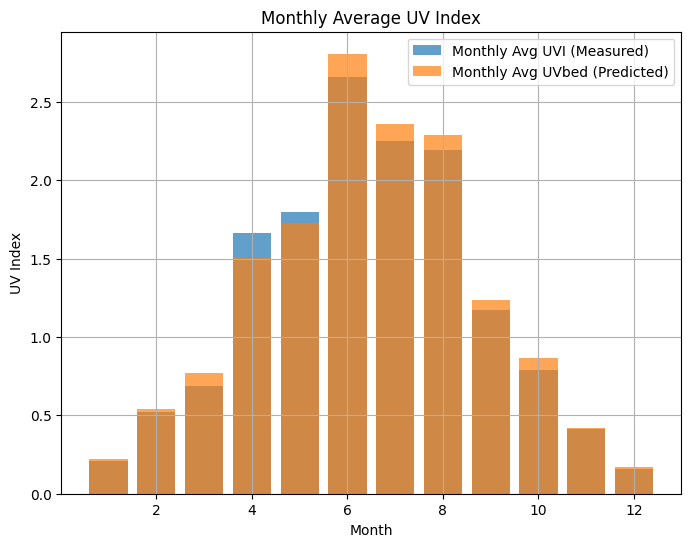

In [20]:
monthly_averages = df_merged.groupby('Month')[['GHI', 'UVI', 'uvbed']].mean()

# Plot monthly averages
plt.figure(figsize=(8, 6))
plt.bar(monthly_averages.index, monthly_averages['UVI'], label='Monthly Avg UVI (Measured)', alpha=0.7)
plt.bar(monthly_averages.index, monthly_averages['uvbed'], label='Monthly Avg UVbed (Predicted)', alpha=0.7)
plt.title('Monthly Average UV Index')
plt.xlabel('Month')
plt.ylabel('UV Index')
plt.legend()
plt.grid()
plt.show()


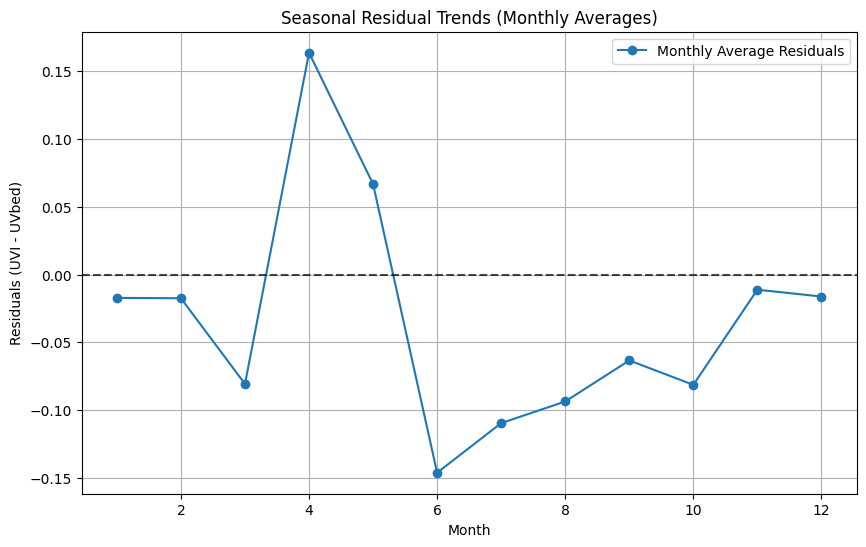

In [25]:
seasonal_residuals = df_merged.groupby('Month')['Residuals_UV'].mean()

# Visualizations
# 1. Seasonal Residual Trends
plt.figure(figsize=(10, 6))
plt.plot(seasonal_residuals.index, seasonal_residuals.values, marker='o', linestyle='-', label='Monthly Average Residuals')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title('Seasonal Residual Trends (Monthly Averages)')
plt.xlabel('Month')
plt.ylabel('Residuals (UVI - UVbed)')
plt.legend()
plt.grid()
plt.show()

Bitte die 2te Option durchführen. (Eine detaillierte Analyse ohne den LSTM-Modellierungsteil durchführen, indem ich stattdessen andere Muster und Beziehungen in den Daten untersuche.)

Erste Analyse:

1. Zeitliche Abdeckung
2. Vorhersagedaten
3. Gemeinsamer Zeitraum

Vergleich zwischen gemessenen und vorhergesagten Daten:

MAE:

RSME:

## Allgemeine Beobachtungen zu den UVI-Messwerten

## Anomalierkennung

Anaomalien wurden auf Basis von 2 Residuen (> 2 Standartabweichungen) identifiziert.

## Saisonale Analyse

## Bewölkungseffekt

## Fehleranalyse nach Stunden und Tagen

## Residuals über die Zeit

## Täglicher Durchschitt der UVI Werte

## Monatlicher Durchschitt der UVI Werte

## Durchschnittliche Residuals in Abhängigkeit der Cloud Cover Levels

## Montalicher Durchschnitt der Residuen

## Größte positive und negative Residuen

## Monatliche Residuen Trends

## Sonstiges bzw. alt...

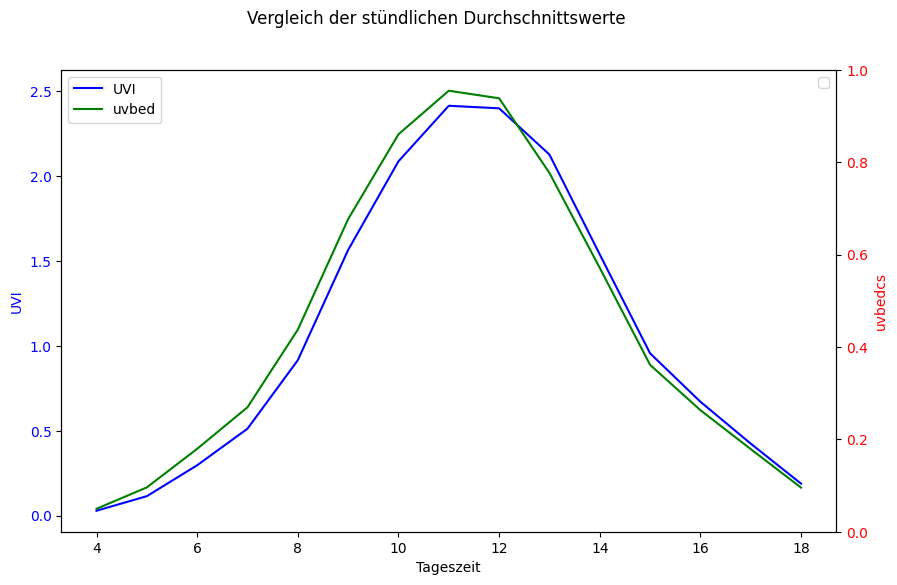

In [19]:
# 2. Stündliche Durchschnittswerte
figsize=(10, 6)
title = 'Vergleich der stündlichen Durchschnittswerte'
x_label = 'Tageszeit'
y1_color = 'b'
y1_label = 'UVI'
y2_color = 'r'
y2_label = 'uvbedcs'
y3_color = 'g'
y3_label = 'uvbed'


fig, ax1 = plt.subplots(figsize = figsize)
ax1.plot(hourly_aggregates.index, hourly_aggregates['UVI'], color = y1_color, label = y1_label)
ax1.plot(hourly_aggregates.index, hourly_aggregates['uvbed'], color = y3_color, label = y3_label)
ax1.set_xlabel(x_label)
ax1.set_ylabel(y1_label, color = y1_color)
ax1.tick_params(axis='y', labelcolor=y1_color)

ax2 = ax1.twinx()
# ax2.plot(hourly_aggregates.index, hourly_aggregates['uvbedcs'], color = y2_color, label = y2_label)
ax2.set_ylabel(y2_label, color = y2_color)
ax2.tick_params(axis='y', labelcolor=y2_color)

# Titel und Legenden
fig.suptitle(title)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Plot anzeigen
plt.show()